# Projet simulation logicielle
* *Rhouch Oussama*
* *Cherki Inssaf*

<img src="figure/model based.png" alt="CS" style="width: 750px;"/>

## Importing libraries

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb=100"
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from scipy.io.wavfile import write
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torchaudio

## Performing preprocessing on the data

##### Unzip the data

In [2]:
zip_file_paths = ['data/data_part1.zip', 'data/data_part2.zip', 'data/data_part3.zip', 'data/data_part4.zip']

for zip_file_path in zip_file_paths:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(".")

##### Data folders

In [3]:
noise_folder = "data/noise/"
clean_folder = "data/clean/dev-clean"
output_folder = "data/noisy/"
denoising_folder = "data/denoising/"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(denoising_folder, exist_ok=True)

### Clean audio data

##### Load clean audio data

In [4]:
# Get the list of clean files
clean_path = []
for folder in os.listdir(clean_folder):
    folder_path = os.path.join(clean_folder, folder)
    if os.path.isdir(folder_path):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".flac"):
                    file_path = os.path.join(root, file)
                    clean_path.append(file_path)

clean_path[-5:]

['data/clean/dev-clean\\8842\\304647\\8842-304647-0009.flac',
 'data/clean/dev-clean\\8842\\304647\\8842-304647-0010.flac',
 'data/clean/dev-clean\\8842\\304647\\8842-304647-0011.flac',
 'data/clean/dev-clean\\8842\\304647\\8842-304647-0012.flac',
 'data/clean/dev-clean\\8842\\304647\\8842-304647-0013.flac']

### Noise audio data

##### Load noise audio data

In [10]:
# Get the list of noise files
noise_file = ""
if os.path.isdir(noise_folder):
        for root, dirs, files in os.walk(noise_folder):
            for file in files:
                if file.endswith(".wav"):
                    noise_file = os.path.join(root, file)

noise_file

'data/noise/babble_16k.wav'

In [121]:
class PerceptronDataset(Dataset):
    def __init__(self, clean_path, noise_file, target_length=None):
        self.clean_files = []
        self.noise_files = []
        self.noisy_files = []
        self.clean_path = clean_path
        self.noise_file = noise_file
        self.target_length = target_length
        self.i = 0
        self.prepare_data()

    def mix(self, clean_audio_path, noise_file):
        s, s_rate = librosa.load(clean_audio_path, sr=16000)
        u_audio, _ = librosa.load(noise_file, sr=16000)

        # Ensure the clean and noisy audio have the same length
        min_length = min(len(s), len(u_audio))
        s = s[:min_length]
        u_audio = u_audio[:min_length]

        s_norm = preprocessing.normalize([s])[0]
        u_norm = preprocessing.normalize([u_audio])[0]

        rsb = 10 * np.log10(np.sum(s_norm**2) / np.sum(u_norm**2))
        alpha = 10**(-rsb / 20)
        x = s_norm + alpha * u_norm
        x = x.astype(np.float32)
        s_norm = s_norm.astype(np.float32)
        u_norm = u_norm.astype(np.float32)
        
        # Assuming output_folder is defined somewhere
        output_path = f"{output_folder}noisy_{self.i}.wav"
        sf.write(output_path, x, s_rate)

        self.i += 1
        
        return torch.tensor(s_norm), torch.tensor(u_norm), torch.tensor(x)

    def resize_dataset(self):
        max_length = max(len(audio) for audio in self.noisy_files + self.clean_files + self.noise_files)

        for i in range(len(self.noisy_files)):
            self.noisy_files[i] = self.resize_audio(self.noisy_files[i], max_length)
            self.clean_files[i] = self.resize_audio(self.clean_files[i], max_length)
            self.noise_files[i] = self.resize_audio(self.noise_files[i], max_length)

    def resize_audio(self, audio, target_length):
        current_length = len(audio)

        if current_length > target_length:
            # Trim the audio if it's longer than the target length
            audio = audio[:target_length]
        elif current_length < target_length:
            # Pad the audio if it's shorter than the target length
            padding = target_length - current_length
            audio = np.pad(audio, (0, padding), 'constant')

        return audio

    def prepare_data(self):
        for clean_audio_path in self.clean_path:
            clean, noise, noisy = self.mix(clean_audio_path, self.noise_file)
            if len(clean) != len(noisy) and len(clean) != len(noise):
                print("Error: clean, noisy, and noise audio have different lengths")
            
            self.clean_files.append(clean)
            self.noise_files.append(noise)
            self.noisy_files.append(noisy)

        # Resize all the data to have the same length
        self.resize_dataset()

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        return self.noisy_files[idx], self.clean_files[idx], self.noise_files[idx]


In [122]:
# Split data into training and test sets (80% training, 20% test)
clean_train, clean_test = train_test_split(clean_path[:60], test_size=0.2, random_state=42)

In [123]:
# Create a PerceptronDataset object for the training set
preprocessor_train = PerceptronDataset(clean_train, noise_file)

# Create a PerceptronDataset object for the test set
preprocessor_test = PerceptronDataset(clean_test, noise_file)

In [124]:
len(preprocessor_train), len(preprocessor_test)

(48, 12)

In [125]:
train_loader = DataLoader(dataset=preprocessor_train, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=preprocessor_test, batch_size=1, shuffle=True)

In [126]:
for x, s, u in train_loader:
    print(x.shape)
    print(s.shape)
    print(u.shape)
    break

torch.Size([1, 470400])
torch.Size([1, 470400])
torch.Size([1, 470400])


In [163]:
class SimplePerceptron(nn.Module):
    def __init__(self):
        super(SimplePerceptron, self).__init__()
        self.fc = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        x = self.fc(x)
        return x

# Instantiate the simple model
simple_perceptron_model = SimplePerceptron()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_perceptron_model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

simple_perceptron_model.to(device)

for epoch in range(num_epochs):
    simple_perceptron_model.train()  # Set the model to training mode

    for batch_idx, (X_noisy, y_clean, _) in enumerate(train_loader):
        X_noisy, y_clean = X_noisy.to(device), y_clean.to(device)

        # Forward pass
        outputs = simple_perceptron_model(X_noisy.unsqueeze(2))
        loss = criterion(outputs, y_clean.unsqueeze(2))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Evaluate on the test set
simple_perceptron_model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for batch_idx, (X_noisy_test, y_clean_test, _) in enumerate(test_loader):
        X_noisy_test, y_clean_test = X_noisy_test.to(device), y_clean_test.to(device)

        # Forward pass
        outputs_test = simple_perceptron_model(X_noisy_test.unsqueeze(2))
        loss_test = criterion(outputs_test, y_clean_test.unsqueeze(2))

        test_loss += loss_test.item()

# Calculate average test loss
average_test_loss = test_loss / len(test_loader)

print(f'Average Test Loss: {average_test_loss:.4f}')


Epoch [1/50], Batch [10/48], Loss: 0.1139
Epoch [1/50], Batch [20/48], Loss: 0.1073
Epoch [1/50], Batch [30/48], Loss: 0.1010
Epoch [1/50], Batch [40/48], Loss: 0.0949
Epoch [2/50], Batch [10/48], Loss: 0.0846
Epoch [2/50], Batch [20/48], Loss: 0.0792
Epoch [2/50], Batch [30/48], Loss: 0.0742
Epoch [2/50], Batch [40/48], Loss: 0.0693
Epoch [3/50], Batch [10/48], Loss: 0.0613
Epoch [3/50], Batch [20/48], Loss: 0.0571
Epoch [3/50], Batch [30/48], Loss: 0.0532
Epoch [3/50], Batch [40/48], Loss: 0.0495
Epoch [4/50], Batch [10/48], Loss: 0.0433
Epoch [4/50], Batch [20/48], Loss: 0.0401
Epoch [4/50], Batch [30/48], Loss: 0.0371
Epoch [4/50], Batch [40/48], Loss: 0.0344
Epoch [5/50], Batch [10/48], Loss: 0.0298
Epoch [5/50], Batch [20/48], Loss: 0.0274
Epoch [5/50], Batch [30/48], Loss: 0.0252
Epoch [5/50], Batch [40/48], Loss: 0.0232
Epoch [6/50], Batch [10/48], Loss: 0.0199
Epoch [6/50], Batch [20/48], Loss: 0.0182
Epoch [6/50], Batch [30/48], Loss: 0.0166
Epoch [6/50], Batch [40/48], Loss:

In [147]:
input_size = train_loader.dataset.noisy_files[0].shape[0]
hidden_size = 128
output_size = train_loader.dataset.clean_files[0].shape[0]

class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        return x

In [148]:
model = Perceptron()

In [149]:
# define the loss function
criterion = nn.MSELoss()

In [150]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [157]:
summary(model, (2000, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 2000, 64]             128
              ReLU-2             [-1, 2000, 64]               0
           Dropout-3             [-1, 2000, 64]               0
            Linear-4             [-1, 2000, 64]           4,160
              ReLU-5             [-1, 2000, 64]               0
           Dropout-6             [-1, 2000, 64]               0
            Linear-7              [-1, 2000, 1]              65
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 5.87
Params size (MB): 0.02
Estimated Total Size (MB): 5.90
----------------------------------------------------------------


In [158]:
# Train the model and optimize it with backpropagation on clean data
train_loss = []
    
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for batch_idx, (X_noisy, y_clean, _) in enumerate(train_loader):
        X_noisy, y_clean = X_noisy.to(device), y_clean.to(device)

        # Forward pass
        outputs = model(X_noisy.unsqueeze(2))
        loss = criterion(outputs, y_clean.unsqueeze(2))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    train_loss.append(loss.item())

# Save the trained model if needed
torch.save(model.state_dict(), 'complex_perceptron_model.pth')

Epoch [1/50], Batch [10/48], Loss: 0.0169
Epoch [1/50], Batch [20/48], Loss: 0.0085
Epoch [1/50], Batch [30/48], Loss: 0.0049
Epoch [1/50], Batch [40/48], Loss: 0.0033
Epoch [2/50], Batch [10/48], Loss: 0.0020
Epoch [2/50], Batch [20/48], Loss: 0.0016
Epoch [2/50], Batch [30/48], Loss: 0.0014
Epoch [2/50], Batch [40/48], Loss: 0.0012
Epoch [3/50], Batch [10/48], Loss: 0.0009
Epoch [3/50], Batch [20/48], Loss: 0.0008
Epoch [3/50], Batch [30/48], Loss: 0.0007
Epoch [3/50], Batch [40/48], Loss: 0.0006
Epoch [4/50], Batch [10/48], Loss: 0.0005
Epoch [4/50], Batch [20/48], Loss: 0.0004
Epoch [4/50], Batch [30/48], Loss: 0.0004
Epoch [4/50], Batch [40/48], Loss: 0.0003
Epoch [5/50], Batch [10/48], Loss: 0.0003
Epoch [5/50], Batch [20/48], Loss: 0.0002
Epoch [5/50], Batch [30/48], Loss: 0.0002
Epoch [5/50], Batch [40/48], Loss: 0.0002
Epoch [6/50], Batch [10/48], Loss: 0.0002
Epoch [6/50], Batch [20/48], Loss: 0.0001
Epoch [6/50], Batch [30/48], Loss: 0.0001
Epoch [6/50], Batch [40/48], Loss:

In [159]:
torch.save(model.state_dict(), 'model_epoch_'+str(epoch)+'.pth')
print('Training complete')
print(loss.data)

Training complete
tensor(2.7611e-06)


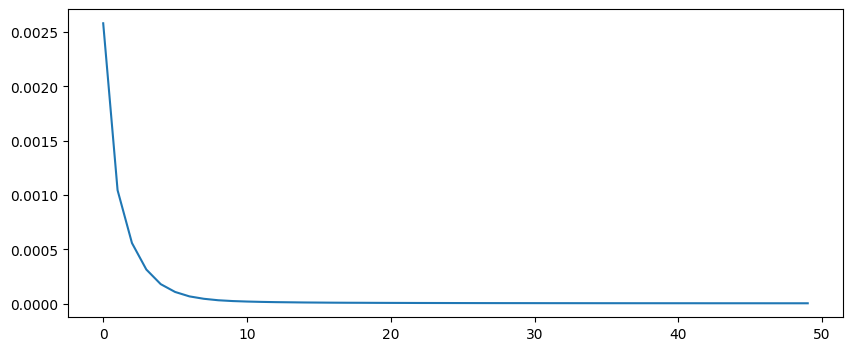

In [160]:
plt.figure(figsize=(10, 4))
plt.plot(range(num_epochs), train_loss, label='Training loss')
plt.show()

In [161]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for batch_idx, (X_noisy_test, y_clean_test, _) in enumerate(test_loader):
        X_noisy_test, y_clean_test = X_noisy_test.to(device), y_clean_test.to(device)

        # Forward pass
        outputs_test = model(X_noisy_test.unsqueeze(2))
        loss_test = criterion(outputs_test, y_clean_test.unsqueeze(2))

        test_loss += loss_test.item()

# Calculate average test loss
average_test_loss = test_loss / len(test_loader)

print(f'Average Test Loss: {average_test_loss:.4f}')


Average Test Loss: 0.0000
